In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# 1. 모델 로드 (최초 실행 시 다운로드됨)
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. 질문 리스트
questions = [
    "What is Sulwhasoo’s brand story?",
    "What does ‘Holistic Beauty’ mean in Sulwhasoo’s philosophy?",
    "What is JAUM Activator® and what does it do for the skin?",
    "When did Sulwhasoo first start using ginseng in skincare?",
    "What are the key herbal ingredients used by Sulwhasoo?",
    "How does Sulwhasoo’s First Care Activating Serum work?",
    "What skin concerns does the Ultimate S Cream target?",
    "How does Sulwhasoo combine traditional herbal medicine with modern science?",
    "Is Sulwhasoo suitable for anti-aging skincare?",
    "Why does Sulwhasoo focus on ginseng in its products?"
]

# 3. 임베딩 생성
question_embeddings = model.encode(questions)

# 4. CSV로 저장
df = pd.DataFrame({
    'question': questions,
    'embedding': question_embeddings.tolist()
})
df.to_csv("question_embeddings_st.csv", index=False)
print("Embedding saved successfully.")


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding saved successfully.


In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

# 1. 크롤링 대상 URL
url = "https://int.sulwhasoo.com/pages/brand-story"

# 2. HTML 가져오기
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# 3. 스크립트/스타일 제거
for tag in soup(['script', 'style', 'noscript']):
    tag.decompose()

# 4. 본문 텍스트만 추출
text = soup.get_text(separator=' ', strip=True)

# 5. 공백 정리
cleaned_text = re.sub(r'\s+', ' ', text)

# 6. 청크 분할 (500자 기준)
chunk_size = 500
chunks = [cleaned_text[i:i+chunk_size] for i in range(0, len(cleaned_text), chunk_size)]

# 7. 데이터프레임 저장
df_chunks = pd.DataFrame({
    'chunk_id': range(len(chunks)),
    'text': chunks
})
df_chunks.to_csv("brand_story_chunks.csv", index=False)

print("Crawling and chunking completed. Total number of chunks:", len(chunks))


Crawling and chunking completed. Total number of chunks: 11


In [3]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. 모델 로드
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. 질문 임베딩 불러오기
df_q = pd.read_csv("question_embeddings_st.csv")
questions = df_q['question'].tolist()
question_vectors = np.array(df_q['embedding'].apply(eval).tolist())

# 3. 청크 불러오기
df_c = pd.read_csv("brand_story_chunks.csv")
chunk_texts = df_c['text'].tolist()

# 4. 청크 임베딩 생성
chunk_vectors = model.encode(chunk_texts)

# 5. 유사도 계산
similarity_matrix = cosine_similarity(question_vectors, chunk_vectors)

# 6. 각 질문별로 가장 유사한 청크 선택
top_matches = []
for i, sim_scores in enumerate(similarity_matrix):
    top_idx = np.argmax(sim_scores)
    top_score = sim_scores[top_idx]
    top_text = chunk_texts[top_idx]
    top_matches.append({
        "question": questions[i],
        "matched_chunk_id": top_idx,
        "similarity_score": round(float(top_score), 4),
        "matched_chunk_text": top_text
    })

# 7. 결과 저장
df_result = pd.DataFrame(top_matches)
df_result.to_csv("question_chunk_similarity_results.csv", index=False)
print("Similarity analysis completed. Results saved to question_chunk_similarity_results.csv")


Similarity analysis completed. Results saved to question_chunk_similarity_results.csv


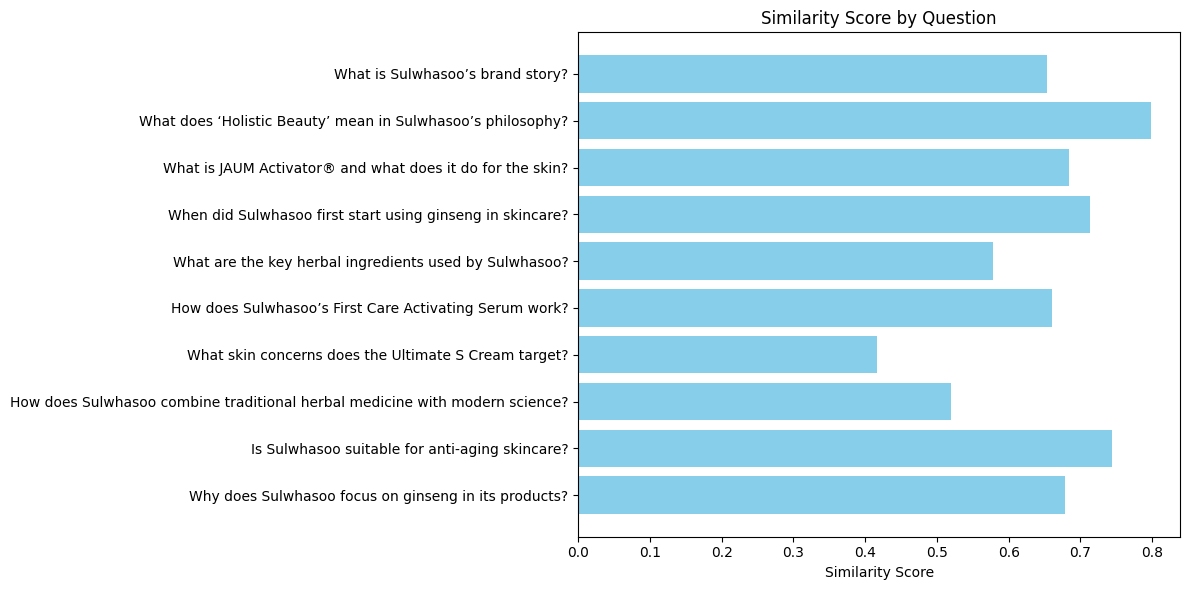

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 결과 불러오기
df = pd.read_csv("question_chunk_similarity_results.csv", encoding="utf-8")

# 2. 시각화용 세팅
plt.figure(figsize=(12, 6))
plt.barh(df['question'], df['similarity_score'], color='skyblue')
plt.xlabel("Similarity Score")
plt.title("Similarity Score by Question")
plt.gca().invert_yaxis()  # 질문 순서 뒤집기 (위가 높은 점수)
plt.tight_layout()
plt.show()


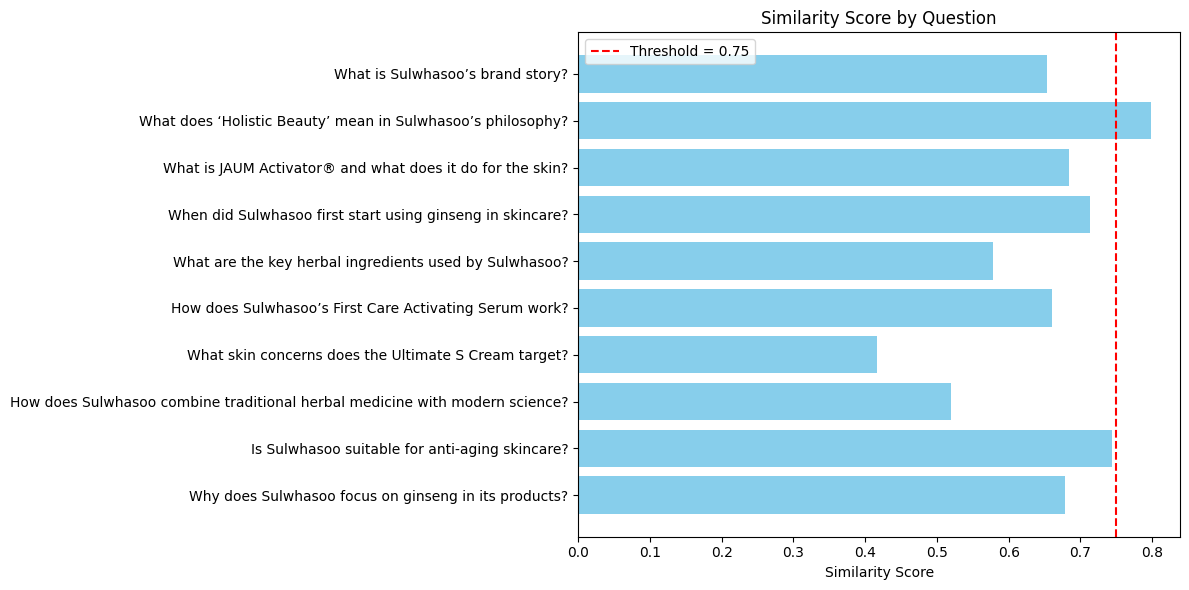

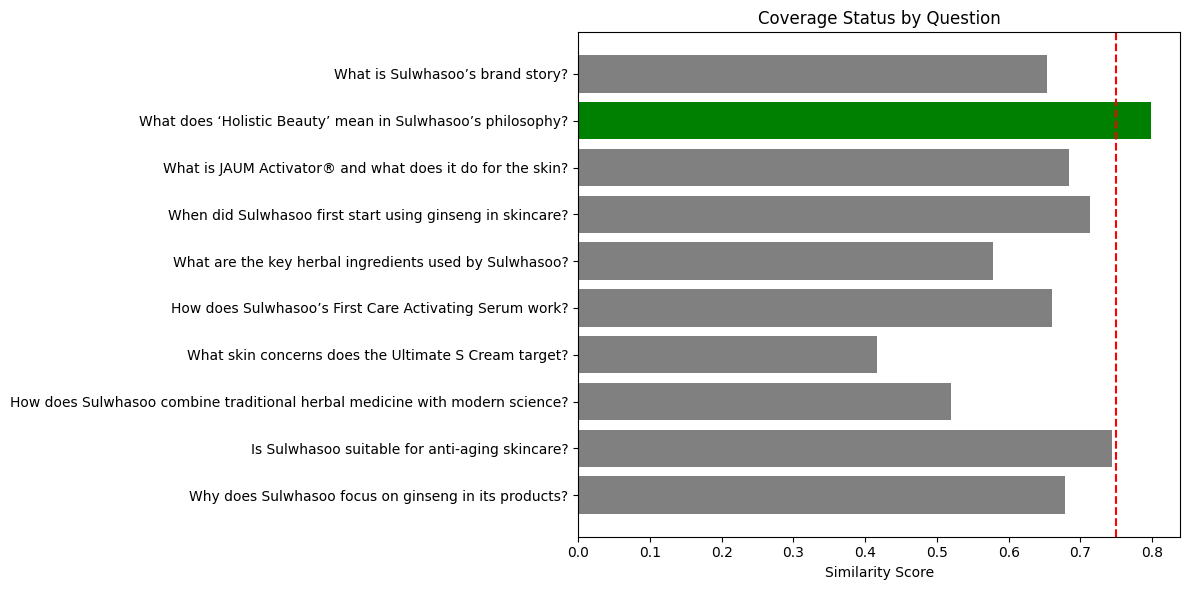

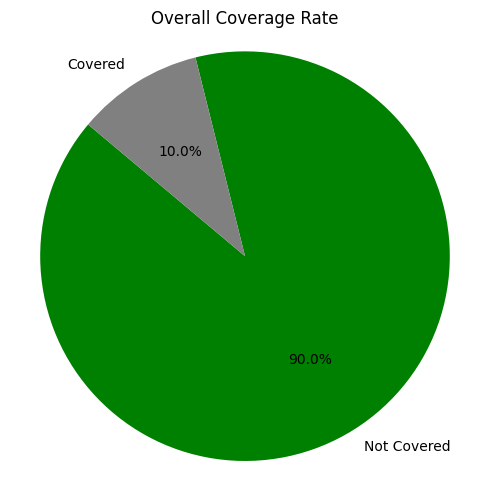

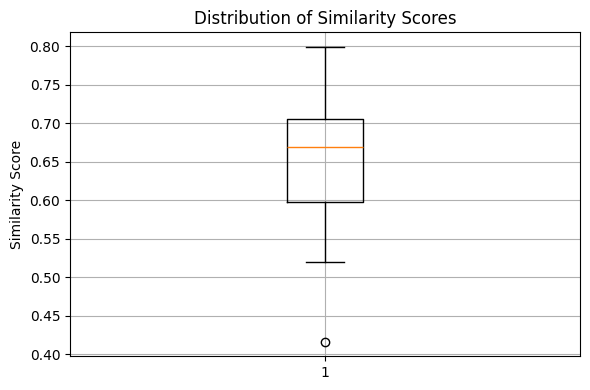

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV 불러오기
df = pd.read_csv("question_chunk_similarity_results.csv", encoding="utf-8")

# 2. 대응 여부 판단 기준
threshold = 0.75
df['status'] = df['similarity_score'].apply(lambda x: 'Covered' if x >= threshold else 'Not Covered')

# 색상 지정
colors = ['green' if s == 'Covered' else 'gray' for s in df['status']]

# -------------------------
# ① 유사도 막대그래프 + 기준선
# -------------------------
plt.figure(figsize=(12, 6))
plt.barh(df['question'], df['similarity_score'], color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.xlabel("Similarity Score")
plt.title("Similarity Score by Question")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -------------------------
# ② 색상 구분 막대그래프 (Covered vs Not Covered)
# -------------------------
plt.figure(figsize=(12, 6))
plt.barh(df['question'], df['similarity_score'], color=colors)
plt.axvline(threshold, color='red', linestyle='--')
plt.xlabel("Similarity Score")
plt.title("Coverage Status by Question")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -------------------------
# ③ 파이 차트: 대응 비율
# -------------------------
coverage_counts = df['status'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(coverage_counts, labels=coverage_counts.index, autopct='%1.1f%%', colors=['green', 'gray'], startangle=140)
plt.title("Overall Coverage Rate")
plt.axis('equal')
plt.tight_layout()
plt.show()

# -------------------------
# ④ 박스플롯: 유사도 분포
# -------------------------
plt.figure(figsize=(6, 4))
plt.boxplot(df['similarity_score'])
plt.title("Distribution of Similarity Scores")
plt.ylabel("Similarity Score")
plt.grid(True)
plt.tight_layout()
plt.show()
